In [2]:
!pip install cplex


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 16.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import cplex
import matplotlib.pyplot as plt
import math


In [5]:
#fixing the values of node and no. of vehicles
n=10
K=3
Q=1
q=0.1

array([[ 0.        ,  6.39533764,  2.05153035, 25.99094382, 13.62802984,
        17.22042622, 44.37465554,  5.71436438,  5.35070338,  0.15551172],
       [ 6.39533764,  0.        , 15.69091624, 51.96609338, 17.97802951,
        44.57746267, 28.86473648, 17.98545114,  8.38325076,  7.30720838],
       [ 2.05153035, 15.69091624,  0.        , 17.04312982, 16.73866158,
         7.39453361, 58.96925826,  4.38161359,  9.36670943,  1.76880218],
       [25.99094382, 51.96609338, 17.04312982,  0.        , 67.09516848,
        12.51722924, 70.31759586, 36.57193312, 21.78996812, 27.40958613],
       [13.62802984, 17.97802951, 16.73866158, 67.09516848,  0.        ,
        32.65871216, 91.64405924,  4.94973084, 34.70045088, 11.22659602],
       [17.22042622, 44.57746267,  7.39453361, 12.51722924, 32.65871216,
         0.        , 99.62052346, 12.42767801, 29.01302165, 15.98308594],
       [44.37465554, 28.86473648, 58.96925826, 70.31759586, 91.64405924,
        99.62052346,  0.        , 81.30016833

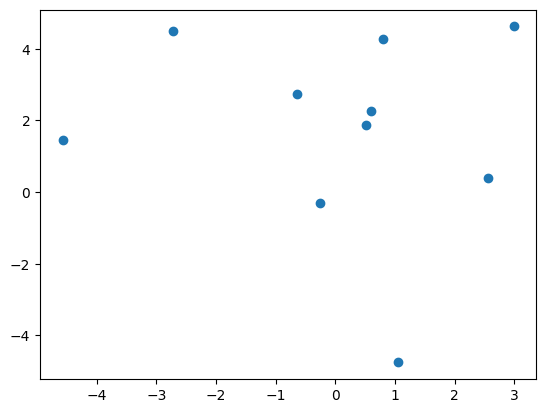

In [6]:
#Generating nodes at random places
np.random.seed(1543)
xp=(np.random.rand(n)-0.5)*10
yp=(np.random.rand(n)-0.5)*10
plt.plot(xp,yp,'o')
distance = np.zeros([n, n])
for i in range (0,n):
    for j in range(0,n):
        distance[i,j]=((xp[i]-xp[j])**2 + (yp[i]-yp[j])**2)
distance

In [7]:
#Setting up the problem
model=cplex.Cplex()
my_obj = list(distance.reshape(1, n**2)[0])+[0.0 for x in range(0, n - 1)]
my_ub=list(1 for i in range(0,n**2))+[Q for i in range(0,n-1)]
my_lb=list(0 for i in range(0,n**2))+[q for i in range(0,n-1)]
my_types="".join(list('I' for i in range(0,n**2)))+ "".join(list('C' for i in range(0,n-1)))
model.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_types)
model.set_log_stream(None)
model.set_error_stream(None)
model.set_warning_stream(None)
model.set_results_stream(None)
model.objective.set_sense(model.objective.sense.minimize)


In [8]:
#Checking the variables used above
print(my_obj)
print(my_lb)
print(my_types)
print(my_ub)

[0.0, 6.395337639663445, 2.051530347203407, 25.990943819978224, 13.62802983953138, 17.220426224849696, 44.374655538524145, 5.714364377300821, 5.350703382978599, 0.15551172190570506, 6.395337639663445, 0.0, 15.690916235016818, 51.966093375373255, 17.97802951014608, 44.57746267133861, 28.864736484580703, 17.985451142233217, 8.383250763672091, 7.307208375156825, 2.051530347203407, 15.690916235016818, 0.0, 17.043129818616613, 16.738661582129183, 7.3945336146118645, 58.96925826285187, 4.381613588835215, 9.36670942913495, 1.7688021847391902, 25.990943819978224, 51.966093375373255, 17.043129818616613, 0.0, 67.0951684845306, 12.517229239274673, 70.31759586002983, 36.57193311828386, 21.789968123847217, 27.40958612645407, 13.62802983953138, 17.97802951014608, 16.738661582129183, 67.0951684845306, 0.0, 32.658712156347356, 91.64405923696978, 4.949730837465915, 34.70045087859716, 11.226596022082951, 17.220426224849696, 44.57746267133861, 7.3945336146118645, 12.517229239274673, 32.658712156347356, 0

In [9]:
#setting up the constrain
my_rhs = (2 * ([K] + [1 for x in range(0, n - 1)])
        + [(Q - q) for x in range(0, (n - 1) ** 2 - (n - 1))]
        + [0 for x in range(0, n)])
rows=list()
for ii in range(0, n):
    col = [x for x in range(0 + n * ii, n + n * ii)]
    coef = [1 for x in range(0, n)]
    rows.append([col, coef])
for ii in range(0, n):
    col = [x for x in range(0 + ii, n**2, n)]
    coef = [1 for x in range(0, n)]
    rows.append([col, coef])
#sub-tour constrain elimination
for ii in range(0, n):
    for jj in range(0, n):
        if (ii != jj) and (ii * jj > 0):
            col = [ii + (jj * n), n**2 + ii - 1, n**2 + jj - 1]
            coef = [1, 1, -1]
            rows.append([col, coef])
for ii in range(0, n):
    col = [(ii) * (n + 1)]
    coef = [1]
    rows.append([col, coef])
my_sense = (
            "".join(["E" for x in range(0, 2 * n)])
            + "".join(["L" for x in range(0, (n - 1) ** 2 - (n - 1))])
            + "".join(["E" for x in range(0, n)]))

model.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)
model.solve()
x = model.solution.get_values()
x = np.array(x)
x=list(x)
cost = model.solution.get_objective_value()

In [10]:
#Checking the variables used above
print(rows)
print(my_rhs)
print(my_sense)
print(x,cost)


[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[50, 51, 52, 53, 54, 55, 56, 57, 58, 59], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[60, 61, 62, 63, 64, 65, 66, 67, 68, 69], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[70, 71, 72, 73, 74, 75, 76, 77, 78, 79], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[80, 81, 82, 83, 84, 85, 86, 87, 88, 89], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[0, 10, 20, 30, 40, 50, 60, 70, 80, 90], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[1, 11, 21, 31, 41, 51, 61, 71, 81, 91], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[2, 12, 22, 32, 42, 52, 62, 72, 82, 92], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], [[3, 13, 23, 33, 43, 53,

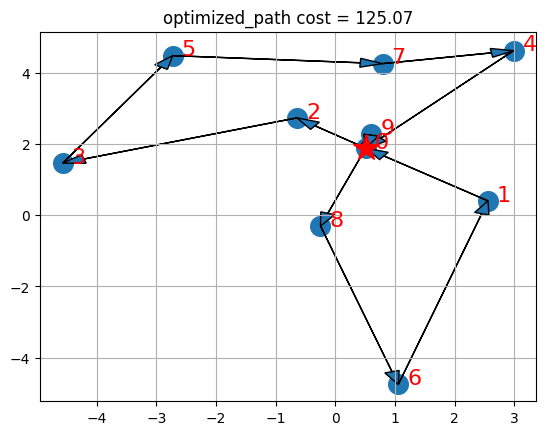

In [11]:
#Visualizing the solution
title_str="optimized_path"
plt.figure()
plt.scatter(xp, yp, s=200)
for i in range(len(xp)):
        plt.annotate(i, (xp[i]+0.15, yp[i]+0), size=16, color="r")
plt.plot(xp[0], yp[0], "r*", ms=20)
plt.grid()
for ii in range(0, n**2):

    if x[ii] > 0:
        ix = ii // n
        iy = ii % n
        plt.arrow(xp[ix],yp[ix],xp[iy] - xp[ix],yp[iy] - yp[ix],length_includes_head=True,head_width=0.25,)
plt.title(title_str + " cost = " + str(int(cost * 100) / 100.0))
plt.show()
